<a href="https://colab.research.google.com/github/addo561/learning-pytorch/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Understand nn.convtranspose

In [1]:
import torch
import torch.nn as nn

In [2]:
m = nn.ConvTranspose2d(1,1,kernel_size=(2,2),stride=2,padding=0)

In [3]:
input = torch.ones(1,1,3,3)
output = m(input)
output.shape

torch.Size([1, 1, 6, 6])

In [4]:
output

tensor([[[[ 0.1511,  0.2025,  0.1511,  0.2025,  0.1511,  0.2025],
          [-0.2564, -0.2048, -0.2564, -0.2048, -0.2564, -0.2048],
          [ 0.1511,  0.2025,  0.1511,  0.2025,  0.1511,  0.2025],
          [-0.2564, -0.2048, -0.2564, -0.2048, -0.2564, -0.2048],
          [ 0.1511,  0.2025,  0.1511,  0.2025,  0.1511,  0.2025],
          [-0.2564, -0.2048, -0.2564, -0.2048, -0.2564, -0.2048]]]],
       grad_fn=<ConvolutionBackward0>)

Unet

In [5]:
import os
if not os.path.exists('dataset1'):
    !wget -q wget -q -O dataset1.zip "https://www.dropbox.com/scl/fi/jv072cyo3y62f6ykw54l8/dataset1.zip?rlkey=mf1tmtrnd6ys7m7oi4ygtcro9&st=vj8bwlik&dl=1"
    !unzip -q dataset1.zip
    !rm dataset1.zip
    %pip install -q torch_snippets pytorch_model_summary lovely_tensors

from torch_snippets import *
init_torch()
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
from torch_snippets.torch_loader import Report

In [7]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [8]:
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim

In [10]:
class SegData(Dataset):
  def __init__(self,split):
    self.items= stems(f'{base}/images_prepped_{split}')
    self.split = split
  def __len__(self):
    return len(self.items)

  def __getitem__(self,ix):
    image = read(f'{base}/images_prepped_{self.split}/{self.items[ix]}.png',1)
    image = cv2.resize(image,(224,224))
    mask = read(f'{base}/annotations_prepped_{self.split}/{self.items[ix]}.png')[:,:,0]
    mask = cv2.resize(mask,(224,224))
    return image,mask
  def choose(self):
    return self[randint(len(self))]

  def collate_fn(self,batch):
    ims,masks = list(zip(*batch))
    ims = torch.stack([tfms(im.copy()/255.) for im in ims]).float().to(device)
    ce_masks = torch.stack([torch.Tensor(mask) for mask in masks]).long().to(device)
    return ims,ce_masks

In [11]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True,
                    collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True,
                    collate_fn=val_ds.collate_fn)

In [13]:
def conv(in_ch,out_ch):
  return nn.Sequential(
      nn.Conv2d(in_ch,out_ch,kernel_size=3,stride=1,padding=1),
      nn.BatchNorm2d(out_ch),
      nn.ReLU(inplace=True)
  )
def up_conv(in_ch,out_ch):
  return nn.Sequential(
      nn.ConvTranspose2d(in_ch,out_ch,kernel_size=2,stride=2),
      nn.ReLU(inplace=True)
  )

In [19]:
from torchvision.models import vgg16_bn
class UNET(nn.Module):
  def __init__(self,pretrained=True,out_ch=12):
    super().__init__()
    self.encoder = vgg16_bn(pretrained=pretrained).features
    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])

    self.bottleneck = nn.Sequential(*self.encoder[34:])
    self.conv_bottleneck = conv(512,1024)

    self.up_conv6 = up_conv(1024,512)
    self.conv6 = conv(512+512,512)
    self.up_conv7 = up_conv(512, 256)
    self.conv7 = conv(256+512,256)
    self.up_conv8 = up_conv(256,128)
    self.conv8 = conv(128+256,128)
    self.up_conv9 = up_conv(128, 64)
    self.conv9 = conv(64 + 128, 64)
    self.up_conv10 = up_conv(64, 32)
    self.conv10 = conv(32 + 64, 32)
    self.conv11 = nn.Conv2d(32, out_ch, kernel_size=1)

  def forward(self,x):
      block1 = self.block1(x)
      block2 = self.block2(block1)
      block3 = self.block3(block2)
      block4 = self.block4(block3)
      block5 = self.block5(block4)

      bottleneck = self.bottleneck(block5)
      x = self.conv_bottleneck(bottleneck)

      x = self.up_conv6(x)
      x = torch.cat([x , block5],dim=1)
      x= self.conv6(x)

      x = self.up_conv7(x)
      x = torch.cat([x,block4],dim=1)
      x = self.conv7(x)

      x = self.up_conv8(x)
      x = torch.cat([x, block3], dim=1)
      x = self.conv8(x)

      x = self.up_conv9(x)
      x = torch.cat([x, block2], dim=1)
      x = self.conv9(x)

      x = self.up_conv10(x)
      x = torch.cat([x, block1], dim=1)
      x = self.conv10(x)

      x = self.conv11(x)

      return x


In [20]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds,targets):
  ce_loss = ce(preds,targets)
  acc = (torch.max(preds,1)[1]==targets).float().mean()
  return ce_loss,acc

def train_batch(model,data,optimizer,criterion):
  model.train()
  ims,ce_masks = data
  _masks = model(ims)
  optimizer.zero_grad()
  loss,acc = criterion(_masks,ce_masks)
  loss.backward()
  optimizer.step()
  return loss.item(),acc.item()
@torch.no_grad()
def validate_batch(model,data,criterion):
  model.eval()
  ims,masks = data
  _masks = model(ims)
  loss,acc = criterion(_masks,masks)
  return   loss.item(),acc.item()

model = UNET().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 20

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
import tqdm
log = Report(n_epochs)
for ex in tqdm.tqdm(range(n_epochs)):
  N = len(trn_dl)
  for bx,data in enumerate(trn_dl):
    loss,acc = train_batch(model,data,optimizer,criterion)
    log.record(ex+(bx+1)/N,trn_loss=loss,trn_acc=acc,end='\r')
  N = len(val_dl)
  for bx,data in enumerate(val_dl):
    loss,acc = validate_batch(model,data,criterion)
    log.record(ex+(bx+1)/N,val_loss=loss,val_acc=acc,end='\r')

  log.report_avgs(ex+1)


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH: 0.901  val_loss: 0.870  val_acc: 0.808  (19.99s - 423.67s remaining)

  5%|▌         | 1/20 [00:20<06:23, 20.21s/it]

EPOCH: 1.000  val_acc: 0.817  trn_loss: 1.270  trn_acc: 0.730  val_loss: 0.840  (20.21s - 384.00s remaining)
EPOCH: 1.990  val_loss: 0.603  val_acc: 0.867  (38.63s - 349.58s remaining)

 10%|█         | 2/20 [00:38<05:45, 19.17s/it]

EPOCH: 2.000  val_acc: 0.830  trn_loss: 0.716  trn_acc: 0.822  val_loss: 0.693  (38.65s - 347.85s remaining)
EPOCH: 2.941  val_loss: 0.537  val_acc: 0.876  (57.13s - 331.43s remaining)

 15%|█▌        | 3/20 [00:57<05:21, 18.91s/it]

EPOCH: 3.000  val_acc: 0.860  trn_loss: 0.595  trn_acc: 0.839  val_loss: 0.545  (57.25s - 324.44s remaining)
EPOCH: 3.921  val_loss: 0.530  val_acc: 0.864  (75.33s - 308.91s remaining)

 20%|██        | 4/20 [01:15<04:58, 18.65s/it]

EPOCH: 4.000  val_acc: 0.870  trn_loss: 0.511  trn_acc: 0.859  val_loss: 0.479  (75.49s - 301.98s remaining)
EPOCH: 4.921  val_loss: 0.677  val_acc: 0.784  (93.88s - 287.68s remaining)

 25%|██▌       | 5/20 [01:34<04:39, 18.62s/it]

EPOCH: 5.000  val_acc: 0.829  trn_loss: 0.499  trn_acc: 0.860  val_loss: 0.571  (94.07s - 282.22s remaining)
EPOCH: 5.950  val_loss: 0.630  val_acc: 0.815  (112.19s - 264.88s remaining)

 30%|███       | 6/20 [01:52<04:18, 18.49s/it]

EPOCH: 6.000  val_acc: 0.834  trn_loss: 0.452  trn_acc: 0.872  val_loss: 0.562  (112.30s - 262.03s remaining)
EPOCH: 6.921  val_loss: 0.501  val_acc: 0.841  (130.71s - 247.02s remaining)

 35%|███▌      | 7/20 [02:10<04:00, 18.52s/it]

EPOCH: 7.000  val_acc: 0.874  trn_loss: 0.407  trn_acc: 0.885  val_loss: 0.428  (130.90s - 243.09s remaining)
EPOCH: 7.950  val_loss: 0.794  val_acc: 0.780  (149.04s - 225.88s remaining)

 40%|████      | 8/20 [02:29<03:41, 18.44s/it]

EPOCH: 8.000  val_acc: 0.810  trn_loss: 0.417  trn_acc: 0.880  val_loss: 0.645  (149.15s - 223.72s remaining)
EPOCH: 8.970  val_loss: 0.428  val_acc: 0.864  (167.55s - 206.01s remaining)

 45%|████▌     | 9/20 [02:47<03:22, 18.45s/it]

EPOCH: 9.000  val_acc: 0.866  trn_loss: 0.389  trn_acc: 0.889  val_loss: 0.429  (167.61s - 204.86s remaining)
EPOCH: 9.990  val_loss: 0.291  val_acc: 0.920  (185.78s - 186.15s remaining)

 50%|█████     | 10/20 [03:05<03:03, 18.37s/it]

EPOCH: 10.000  val_acc: 0.868  trn_loss: 0.352  trn_acc: 0.900  val_loss: 0.413  (185.80s - 185.80s remaining)
EPOCH: 10.950  val_loss: 0.400  val_acc: 0.876  (204.17s - 168.73s remaining)

 55%|█████▌    | 11/20 [03:24<02:45, 18.40s/it]

EPOCH: 11.000  val_acc: 0.856  trn_loss: 0.333  trn_acc: 0.905  val_loss: 0.474  (204.28s - 167.14s remaining)
EPOCH: 11.990  val_loss: 0.422  val_acc: 0.873  (222.50s - 148.64s remaining)

 60%|██████    | 12/20 [03:42<02:26, 18.35s/it]

EPOCH: 12.000  val_acc: 0.877  trn_loss: 0.311  trn_acc: 0.912  val_loss: 0.418  (222.52s - 148.35s remaining)
EPOCH: 12.990  val_loss: 0.302  val_acc: 0.910  (240.93s - 130.01s remaining)

 65%|██████▌   | 13/20 [04:00<02:08, 18.38s/it]

EPOCH: 13.000  val_acc: 0.875  trn_loss: 0.295  trn_acc: 0.917  val_loss: 0.409  (240.96s - 129.75s remaining)
EPOCH: 13.970  val_loss: 0.383  val_acc: 0.889  (259.15s - 111.85s remaining)

 70%|███████   | 14/20 [04:19<01:50, 18.34s/it]

EPOCH: 14.000  val_acc: 0.865  trn_loss: 0.286  trn_acc: 0.919  val_loss: 0.477  (259.21s - 111.09s remaining)
EPOCH: 14.990  val_loss: 0.603  val_acc: 0.816  (277.66s - 92.80s remaining)

 75%|███████▌  | 15/20 [04:37<01:31, 18.38s/it]

EPOCH: 15.000  val_acc: 0.866  trn_loss: 0.276  trn_acc: 0.922  val_loss: 0.468  (277.69s - 92.56s remaining)
EPOCH: 15.980  val_loss: 0.354  val_acc: 0.901  (295.98s - 74.45s remaining)

 80%|████████  | 16/20 [04:56<01:13, 18.37s/it]

EPOCH: 16.000  val_acc: 0.885  trn_loss: 0.266  trn_acc: 0.925  val_loss: 0.414  (296.03s - 74.01s remaining)
EPOCH: 16.970  val_loss: 0.304  val_acc: 0.918  (314.38s - 56.13s remaining)

 85%|████████▌ | 17/20 [05:14<00:55, 18.38s/it]

EPOCH: 17.000  val_acc: 0.896  trn_loss: 0.253  trn_acc: 0.929  val_loss: 0.370  (314.45s - 55.49s remaining)
EPOCH: 17.990  val_loss: 0.404  val_acc: 0.883  (332.69s - 37.17s remaining)

 90%|█████████ | 18/20 [05:32<00:36, 18.35s/it]

EPOCH: 18.000  val_acc: 0.889  trn_loss: 0.245  trn_acc: 0.931  val_loss: 0.404  (332.71s - 36.97s remaining)
EPOCH: 18.970  val_loss: 0.413  val_acc: 0.894  (351.17s - 19.06s remaining)

 95%|█████████▌| 19/20 [05:51<00:18, 18.40s/it]

EPOCH: 19.000  val_acc: 0.895  trn_loss: 0.242  trn_acc: 0.932  val_loss: 0.389  (351.24s - 18.49s remaining)
EPOCH: 19.990  val_loss: 0.234  val_acc: 0.931  (369.42s - 0.18s remaining)

100%|██████████| 20/20 [06:09<00:00, 18.47s/it]

EPOCH: 20.000  val_acc: 0.898  trn_loss: 0.228  trn_acc: 0.936  val_loss: 0.359  (369.44s - 0.00s remaining)


100%|██████████| 121/121 [00:00<00:00, 1854.90it/s]


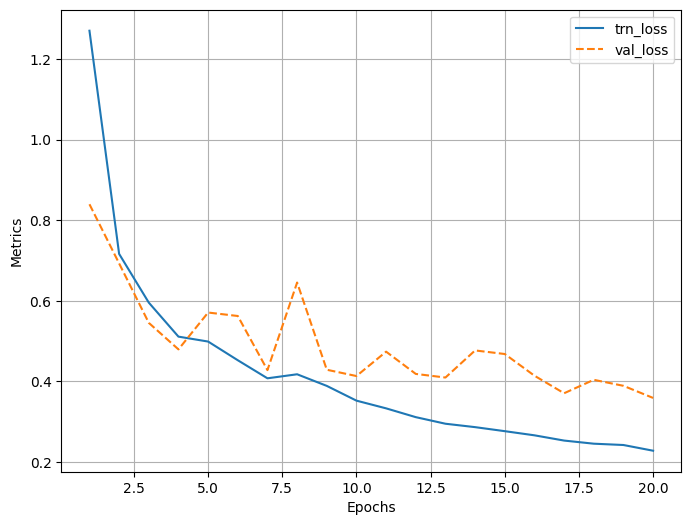

In [22]:
log.plot_epochs(['trn_loss','val_loss'])

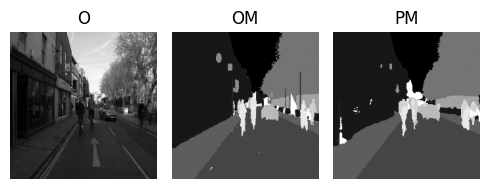

In [32]:
im,mask = next(iter(val_dl))
_mask = model(im)
_,_mask = torch.max(_mask,dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0],
          mask.permute(1,2,0).detach().cpu()[:,:,0],
          _mask.permute(1,2,0).detach().cpu()[:,:,0]],nc=3,titles=['O','OM','PM'])